# Predicting the risk of heart disease in American patients from health data

## Analysing the *Indicators of Heart Disease (2022 update)* dataset

Source: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease  
Contents: responses of >400k adults to an annual health survey from the CDC in the USA

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
import re
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
)
from mlflow import MlflowClient
import lightgbm as lgb
from sklearn.metrics import average_precision_score
import mlflow
import shap
import src.utils as uu
import warnings

warnings.filterwarnings("ignore")

## Imports and description

In [3]:
data_full = pd.read_csv("data/2022/heart_2022_with_nans.csv")
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

Most features are categorical (including many flag columns, such as `sex` or `HadAngina`), with the exception of the following continuous variables `PhysicalHealthDays`, `MentalHealthDays`, `SleepHours`, `HeightInMeters`, `WeightInKilograms`, `BMI`.

### Transforming binary columns

In [4]:
for col in data_full.select_dtypes("O").columns:
    data_full = uu.convert_binary(data_full, col)

In [5]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         445132 non-null  int64  
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             445132 non-null  int64  
 10  HadAngina                  445132 non-null  int64  
 11  HadStroke                  445132 non-null  int64  
 12  HadAsthma                  445132 non-null  int64  
 13  HadSkinCancer              44

Several variables that seem to be binary by definition actually have more than 2 modalities. We can monitor these modalities in order to identify whether some of them deserve to be removed and/or associated with others.

In [6]:
for col in ["HadDiabetes", "CovidPos", "TetanusLast10Tdap"]:
    print(f"Colonne {col} :\n{data_full[col].value_counts()}\n")

Colonne HadDiabetes :
HadDiabetes
No                                         368722
Yes                                         61158
No, pre-diabetes or borderline diabetes     10329
Yes, but only during pregnancy (female)      3836
Name: count, dtype: int64

Colonne CovidPos :
CovidPos
No                                                               270055
Yes                                                              110877
Tested positive using home test without a health professional     13436
Name: count, dtype: int64

Colonne TetanusLast10Tdap :
TetanusLast10Tdap
No, did not receive any tetanus shot in the past 10 years    121493
Yes, received tetanus shot but not sure what type            113725
Yes, received Tdap                                            99943
Yes, received tetanus shot, but not Tdap                      27455
Name: count, dtype: int64



Regarding diabetes, we choose to classify borderline cases as positive (because of the risk of developing diabetes in the longer term), and cases of gestational diabetes as negative (because they are only transient).  
In the case of COVID, we choose to classify as positive cases where only a self-test was performed.  
In the case of the tetanus vaccine, we choose to classify all positive cases together.

In [7]:
data_full.loc[
    data_full["HadDiabetes"] == "No, pre-diabetes or borderline diabetes", "HadDiabetes"
] = "Yes"
data_full.loc[
    data_full["HadDiabetes"] == "Yes, but only during pregnancy (female)", "HadDiabetes"
] = "No"
data_full.loc[data_full["CovidPos"] != "No", "CovidPos"] = "Yes"
data_full["TetanusLast10Tdap"] = (
    data_full["TetanusLast10Tdap"]
    .astype(str)
    .apply(lambda x: "Yes" if "yes" in x.lower() else x)
)
for col in ["HadDiabetes", "CovidPos", "TetanusLast10Tdap"]:
    data_full = uu.convert_binary(data_full, col)

### Deduplication

In [8]:
data_full.duplicated().sum()

184

In [9]:
data_full = data_full.drop_duplicates()

### Cleaning of continuous variables

In [10]:
data_full.select_dtypes("float").describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434026.000000,435886.000000,439500.000000,416465.000000,403040.000000,396312.000000
mean,4.349643,4.384435,7.022874,1.702691,83.074813,28.529956
std,8.690170,8.388730,1.502642,0.107178,21.448172,6.554916
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Several apparently outlier values:
- BMI of 99.6
- 1 or 24 hours of sleep

As it stands, it is difficult to know whether the extreme values ​​(0 or 30 days) for Physical/Mental Health Days are outliers, as the dataset description is not exhaustive. When in doubt, outliers will be eliminated from these two columns, as well as from the Sleep Hours column, based on Tukey's criterion.  
For BMI, it is preferable to re-imput all values ​​using the known formula (weight in kilograms / height squared). This will make it possible to determine extreme BMI values, and therefore any outlier height-weight relationships.

In [11]:
data_full["BMI"] = data_full["WeightInKilograms"] / data_full["HeightInMeters"] ** 2
for col in ["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "BMI"]:
    data_full = uu.tukey(data_full, col)
data_full.loc[data_full["BMI"].isna(), "HeightInMeters"] = np.nan
data_full.loc[data_full["BMI"].isna(), "WeightInKilograms"] = np.nan

### Cleaning of categorical variables

In [12]:
for col in data_full.select_dtypes("O").columns:
    print(f"Column {col} :\n{data_full[col].value_counts()}\n")

Column State :
State
Washington              26138
New York                17780
Minnesota               16815
Ohio                    16481
Maryland                16408
Texas                   14236
Florida                 13384
Wisconsin               11273
Kansas                  11243
Massachusetts           11027
California              10948
Maine                   10645
Indiana                 10458
Virginia                10414
Arizona                 10183
Michigan                10053
South Carolina          10031
Utah                     9822
Connecticut              9771
Colorado                 9360
Georgia                  9234
Iowa                     8948
Vermont                  8800
New Jersey               8195
Hawaii                   7747
Nebraska                 7472
Missouri                 7438
South Dakota             7422
Montana                  7047
New Hampshire            6754
Idaho                    6280
Rhode Island             5891
Alaska             

The following changes are being made:
- Removal of the `State` column, which will not be usable given the number of categories.
- Transformation of the `GeneralHealth` column into a score ranging from 0 to 4.
- Aggregation of the `Current smoker` categories into the `SmokerStatus` column.
- Aggregation of the `Use them` categories into the `ECigaretteUsage` column.
- Aggregation of the `Other race` and `Multiracial` categories into the `RaceEthnicityCategory` column.
- Aggregation of the age categories into the median age of each category.

In [13]:
data_full = data_full.drop(columns="State", errors="ignore")
data_full["LastCheckupTime"] = data_full["LastCheckupTime"].map(
    lambda x: {
        "Within past year (anytime less than 12 months ago)": "Recently",
        "Within past 2 years (1 year but less than 2 years ago)": "Intermediate",
        "Within past 5 years (2 years but less than 5 years ago)": "Intermediate",
        "5 or more years ago": "Ancient",
    }.get(x, x)
)
data_full["GeneralHealth"] = data_full["GeneralHealth"].map(
    lambda x: {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}.get(
        x, x
    )
)
data_full["RemovedTeeth"] = data_full["RemovedTeeth"].map(
    lambda x: {
        "None of them": "None",
        "1 to 5": "Few",
        "6 or more, but not all": "Many",
        "All": "Many",
    }.get(x, x)
)
data_full["SmokerStatus"] = data_full["SmokerStatus"].map(
    lambda x: {
        "Current smoker - now smokes every day": "Current",
        "Current smoker - now smokes some days": "Current",
        "Never smoked": "Never",
        "Former smoker": "Former",
    }.get(x, x)
)
data_full["ECigaretteUsage"] = data_full["ECigaretteUsage"].map(
    lambda x: {
        "Use them some days": "Current",
        "Use them every day": "Current",
        "Never used e-cigarettes in my entire life": "Never",
        "Not at all (right now)": "Former",
    }.get(x, x)
)
data_full["RaceEthnicityCategory"] = data_full["RaceEthnicityCategory"].map(
    lambda x: {
        "Other race only, Non-Hispanic": "Other",
        "Multiracial, Non-Hispanic": "Other",
        "White only, Non-Hispanic": "White",
        "Black only, Non-Hispanic": "Black",
    }.get(x, x)
)


# Converting ages
def extract_age_range(age_range):
    match = re.findall(r"\d+", age_range)
    if len(match) == 2:
        return (int(match[0]) + int(match[1])) / 2
    elif len(match) == 1:
        return int(match[0]) + 5
    else:
        return None


mapping = {
    val: extract_age_range(val) for val in data_full["AgeCategory"].astype(str).unique()
}
data_full["AgeCategory"] = data_full["AgeCategory"].astype(str).map(mapping)

## Preprocessing

### Defining the target

`HadAngina` can theoretically be considered a precursor to a myocardial infarction. It is therefore interesting to look into the possibility of directly predicting heart attacks using this variable. If this risk exists, then it will be important not to use this variable as a feature, so as not to train a model on a trivial problem.

In [14]:
data_full[["HadHeartAttack", "HadAngina"]].corr()

,HadHeartAttack,HadAngina
HadHeartAttack,1.000000,0.428023
HadAngina,0.428023,1.000000


In fact, a correlation coefficient of 42.8% does not seem sufficient to designate `HadAngina` as a sufficient predictor of the `HadHeartAttack` variable on its own. Therefore, we choose to keep this variable as a feature of the model.  
In a second step, we will retest the model without this feature, to see if we can maintain comparable performance without it.

### Train-test split

In [15]:
y = data_full["HadHeartAttack"]
X = data_full.drop(columns=["HadHeartAttack"])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

### Missing values imputations

In [16]:
print(f"Number of columns with all values: {(data_full.isna().mean()==0).sum()}")
print(f"Number of columns with missing values: {(data_full.isna().mean()>0).sum()}")
print(data_full.isna().mean())

Number of columns with all values: 26
Number of columns with missing values: 13
Sex                          0.000000
GeneralHealth                0.002681
PhysicalHealthDays           0.186966
MentalHealthDays             0.156088
LastCheckupTime              0.018656
PhysicalActivities           0.000000
SleepHours                   0.028561
RemovedTeeth                 0.025518
HadHeartAttack               0.000000
HadAngina                    0.000000
HadStroke                    0.000000
HadAsthma                    0.000000
HadSkinCancer                0.000000
HadCOPD                      0.000000
HadDepressiveDisorder        0.000000
HadKidneyDisease             0.000000
HadArthritis                 0.000000
HadDiabetes                  0.000000
DeafOrHardOfHearing          0.000000
BlindOrVisionDifficulty      0.000000
DifficultyConcentrating      0.000000
DifficultyWalking            0.000000
DifficultyDressingBathing    0.000000
DifficultyErrands            0.000000
SmokerSt

The frequency of missing values ranges from 2.0% to 18.7% in a third of columns. These values are imputed with the following strategy:
- Missing values in categorical columns are imputed to the most frequent modality.
- Missing values in continuous columns are imputed by regression from the other columns (through an iterative process, based on the `IterativeImputer` algorithm from `scikit-learn`). The regression models trained on the training set are directly used for the imputation of missing values in the test set.

In [17]:
X_train, X_test = uu.impute(X_train, X_test, strategy="iterative")

[IterativeImputer] Completing matrix with shape (333711, 8)
[IterativeImputer] Ending imputation round 1/30, elapsed time 1.65
[IterativeImputer] Change: 2.2962604594327116, scaled tolerance: 0.0074755831532254185 
[IterativeImputer] Ending imputation round 2/30, elapsed time 3.23
[IterativeImputer] Change: 0.6453738247045133, scaled tolerance: 0.0074755831532254185 
[IterativeImputer] Ending imputation round 3/30, elapsed time 4.61
[IterativeImputer] Change: 0.10991029860565153, scaled tolerance: 0.0074755831532254185 
[IterativeImputer] Ending imputation round 4/30, elapsed time 6.27
[IterativeImputer] Change: 0.04741195304743584, scaled tolerance: 0.0074755831532254185 
[IterativeImputer] Ending imputation round 5/30, elapsed time 7.83
[IterativeImputer] Change: 0.04520851002068186, scaled tolerance: 0.0074755831532254185 
[IterativeImputer] Ending imputation round 6/30, elapsed time 9.61
[IterativeImputer] Change: 0.043184777027103036, scaled tolerance: 0.0074755831532254185 
[Iter

### One-hot encoding of categorical variables

In [18]:
encoder = OneHotEncoder(drop="if_binary", sparse_output=False)
encoded_columns_train = encoder.fit_transform(X_train.select_dtypes("O"))
encoded_columns_train = pd.DataFrame(
    encoded_columns_train,
    columns=encoder.get_feature_names_out(X_train.select_dtypes("O").columns),
)
encoded_columns_test = pd.DataFrame(
    encoder.transform(X_test.select_dtypes("O")), columns=encoded_columns_train.columns
)
X_train = X_train.drop(columns=encoder.feature_names_in_).reset_index(drop=True)
X_train = pd.concat([X_train, encoded_columns_train], axis=1)
X_test = X_test.drop(columns=encoder.feature_names_in_).reset_index(drop=True)
X_test = pd.concat([X_test, encoded_columns_test], axis=1)

### Feature engineering

In [19]:
for col in X_train.columns:
    X_train = uu.create_polynomial(X_train, col)
    X_test = uu.create_polynomial(X_test, col)

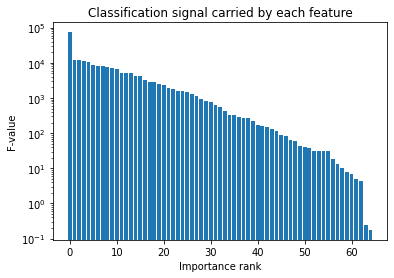

In [20]:
Fvals, pvals = f_classif(X_train, y_train)
plt.bar(np.arange(len(Fvals)), np.sort(Fvals)[::-1])
plt.xlabel("Importance rank")
plt.ylabel("F-value")
plt.title("Classification signal carried by each feature")
plt.yscale("log")

We choose to select the 40 features with the highest importance.

In [21]:
thr_fval = np.sort(Fvals)[::-1][40]
cols_tokeep = Fvals > thr_fval
X_train = X_train.iloc[:, cols_tokeep]
X_test = X_test.iloc[:, cols_tokeep]

## Modelling

In [22]:
client = MlflowClient(tracking_uri="sqlite:///heart_disease.db")

### Exploration of several approaches

In [22]:
experiment_description = "This experiment explores a few simple modelling algorithms to learn to predict the risk of heart attack."

experiment_tags = {
    "project_name": "heart-disease",
    "mlflow.note.content": experiment_description,
}

general_experiment = client.create_experiment(
    name="General exploration", tags=experiment_tags
)

In [23]:
results = []

In [ ]:
clf = DummyClassifier()
results.append(
    uu.evaluate_model(
        clf, X_train, y_train, X_test, y_test, "General exploration", k=5, name="Dummy"
    )
)

2025/10/10 13:11:39 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [25]:
clf = LogisticRegression(penalty="l2", C=1, n_jobs=-2, class_weight="balanced")
results.append(
    uu.evaluate_model(
        clf, X_train, y_train, X_test, y_test, "General exploration", k=5, name="LogReg"
    )
)

2025/10/10 13:12:02 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [26]:
clf = LinearSVC(penalty="l2", C=1, class_weight="balanced")
results.append(
    uu.evaluate_model(
        clf, X_train, y_train, X_test, y_test, "General exploration", k=5, name="SVM"
    )
)

2025/10/10 13:12:20 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [27]:
clf = RandomForestClassifier(
    n_estimators=100, criterion="log_loss", n_jobs=-2, class_weight="balanced"
)
results.append(
    uu.evaluate_model(
        clf, X_train, y_train, X_test, y_test, "General exploration", k=5, name="RF"
    )
)

2025/10/10 13:13:36 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [28]:
clf = LGBMClassifier(n_estimators=1000, class_weight="balanced")
results.append(
    uu.evaluate_model(
        clf, X_train, y_train, X_test, y_test, "General exploration", k=5, name="Boost"
    )
)

[LightGBM] [Info] Number of positive: 15032, number of negative: 251936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 266968, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.878283	valid_0's binary_logloss: 0.417161
[LightGBM] [Info] Number of positive: 15032, number of negative: 251937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

2025/10/10 13:13:58 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


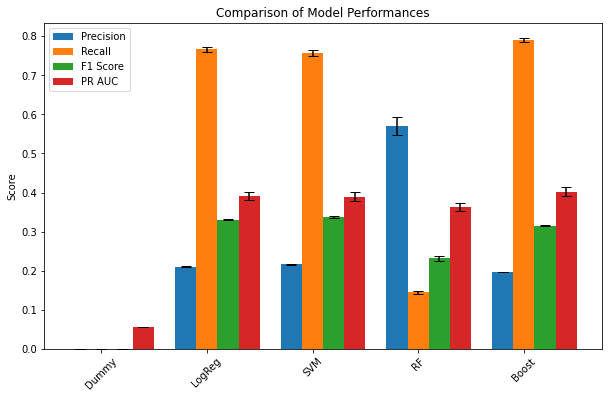

In [29]:
uu.plot_model_performance(results)

![MLFlow screenshot](general_exploration_mlflow.png "Title")


All models generally achieve a performance increase over the baseline (*Dummy Classifier*). There can be considerable variation between models in terms of recall and precision: for example, gradient boosting is better for recall and random forest is better for precision, but both have a lower F1 than the linear models tested.  
However, precision and recall co-vary depending on the chosen separation threshold, which can be modified depending on the interest in the model. In this case, the model with the best precision-recall compromise appears to be gradient boosting, as it has a higher AUC of the precision-recall curve than the others. This model will therefore be chosen for hyperparameterization.

### Optimisation

Firstly, given the strong class imbalance on the target, it is interesting to consider using another loss for training the gradient boosting model. In particular, the *focal loss* is a function derived from the *binary cross-entropy* allowing to give more weight to the strongest errors. This could be of interest given the potential number of false positives in this dataset.

In [ ]:
experiment_description = "This experiment aims to optimize the gradient boosting machine to predict the risk of heart attack."

experiment_tags = {
    "project_name": "heart-disease",
    "mlflow.note.content": experiment_description,
}

general_experiment = client.create_experiment(name="Optimize GBM", tags=experiment_tags)

In [ ]:
score_mean, score_std = uu.gradient_boosting_focal(
    X_train, y_train, experiment="Optimize GBM", k=5, early_stopping_rounds=50
)
print(
    f"Using the focal loss yields the following performance: PR AUC = {score_mean:.3f}±{score_std:.3f}."
)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.150803
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.149602
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.161198
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.163356
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.149995
Using the focal loss yields the following performance: PR AUC = 0.049±0.008.


Using focal loss gives very poor performances, about as good as a dummy classifier. So we stick to using binary cross-entropy.

In a second step, we seek to hyperparameterize the gradient boosting model. To do this, we use the Tree Parzen Estimator algorithm implemented in Optuna to explore the hyperparameter space more efficiently. We choose to increase the number of *ei estimates* and move to a multivariate model in order to further explore hyperparameter combinations.

In [ ]:
study = uu.hyperparameterize(
    X_train,
    y_train,
    n_trials=100,
    experiment="Optimize GBM",
    k=5,
    early_stopping_rounds=10,
)

In [44]:
plot_optimization_history(study)

The PR AUC used here as a hyperparameterization objective tends to have difficulty increasing beyond 10 trials. This might be due to the number of dimensions simultaneously explored.

In [47]:
plot_param_importances(study)

To attempt hyperparameterization again, we will focus on the 4 most important hyperparameters: `learning_rate`, `num_leaves`, `subsample`, and `max_depth`.

In [46]:
plot_slice(study)

In [48]:
study = uu.hyperparameterize(
    X_train,
    y_train,
    n_trials=50,
    k=5,
    experiment="Optimize GBM",
    early_stopping_rounds=10,
    params_to_optimize={
        "num_leaves": [30, 100],
        "max_depth": [3, 12],
        "learning_rate": [2e-2, 0.2],
        "subsample": [0.5, 1.0],
    },
)

In [49]:
plot_optimization_history(study)

The exploration of a narrower hyperparameter space leads to a more consistent increase in performance over trials.

In [ ]:
final_model = LGBMClassifier(
    **study.best_params, n_estimators=1000, n_jobs=-2, class_weight="balanced"
)
mlflow.set_tracking_uri("sqlite:///heart_disease.db")
mlflow.set_experiment("Optimize GBM")
with mlflow.start_run() as run:
    final_model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(10)],
    )
    y_proba_pred = final_model.predict_proba(X_test)[:, 1]
    mlflow.log_params({"model": "Boost", "loss": "BCE", **study.best_params})
    mlflow.log_metric(
        "average_precision", average_precision_score(y_test, y_proba_pred)
    )
    mlflow.lightgbm.log_model(
        lgb_model=final_model,
        input_example=X_test.astype("float"),
        artifact_path="boosting_final_model",
    )
precisions, recalls, thr = precision_recall_curve(y_test, y_proba_pred)
f1s = [2 / ((1 / r) + (1 / pr)) for r, pr in zip(recalls, precisions)]
print("The model is able to predict future heart attacks with:")
print(f"- a precision of {precisions[np.argmax(f1s)]*100:.2f}%")
print(f"- a recall of {recalls[np.argmax(f1s)]*100:.2f}%")
print(f"- a F1 score of {np.max(f1s)*100:.2f}%")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.888506	valid_0's binary_logloss: 0.415912


2025/10/10 16:02:38 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


The model is able to predict future heart attacks with:
- a precision of 44.15%
- a recall of 51.04%
- a F1 score of 47.35%


### Testing the effect of the `HadAngina` feature

As previously stated, it is possible that the ` HadAngina` feature is a confounding variable, whose statistical relationship with the target is too strong, so that its inclusion in the set of feature might be a data leakage. To test this hypothesis, we proceed to the ablation of this feature while retraining the best model found so far.

In [ ]:
final_model_no_angina = LGBMClassifier(
    **study.best_params, n_estimators=1000, n_jobs=-2, class_weight="balanced"
)
with mlflow.start_run() as run:
    final_model_no_angina.fit(
        X_train.drop(columns="HadAngina"),
        y_train,
        eval_set=[(X_test.drop(columns="HadAngina"), y_test)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(10)],
    )
    y_proba_pred = final_model_no_angina.predict_proba(
        X_test.drop(columns="HadAngina")
    )[:, 1]
    mlflow.log_params(
        {"model": "Boost", "loss": "BCE", "HadAngina": "dropped", **study.best_params}
    )
    score = average_precision_score(y_test, y_proba_pred)
    mlflow.log_metric("average_precision", score)
    mlflow.lightgbm.log_model(
        lgb_model=final_model_no_angina,
        input_example=X_test.drop(columns="HadAngina").astype("float"),
        artifact_path="boosting_final_model_no_angina",
    )
    print(
        f"When removing the feature `HadAngina`, the PR AUC of the model on the test set drops to {score:.4f}."
    )
precisions, recalls, thr = precision_recall_curve(y_test, y_proba_pred)
f1s = [2 / ((1 / r) + (1 / pr)) for r, pr in zip(recalls, precisions)]
print(
    "When removing the feature `HadAngina`, the model is able to predict future heart attacks with:"
)
print(f"- a precision of {precisions[np.argmax(f1s)]*100:.2f}%")
print(f"- a recall of {recalls[np.argmax(f1s)]*100:.2f}%")
print(f"- a F1 score of {np.max(f1s)*100:.2f}%")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's auc: 0.847511	valid_0's binary_logloss: 0.487969


2025/10/10 16:03:11 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


When removing the feature `HadAngina`, the PR AUC of the model on the test set drops to 0.2694.
When removing the feature `HadAngina`, the model is able to predict future heart attacks with:
- a precision of 25.09%
- a recall of 47.34%
- a F1 score of 32.80%


It seems that the feature `HadAngina` mostly has an effect on the precision of the model predictions: after the ablation, it drops from 44% to 25%, whereas the recall stays around 50%.

## Explainability

We calculate Shapley values ​​to identify the most important features in the model's predictions. This explainability analysis is crucial because, even if the model's predictions are still far from perfect, it can help identify underestimated factors that may increase the likelihood of developing heart disease.

In [27]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

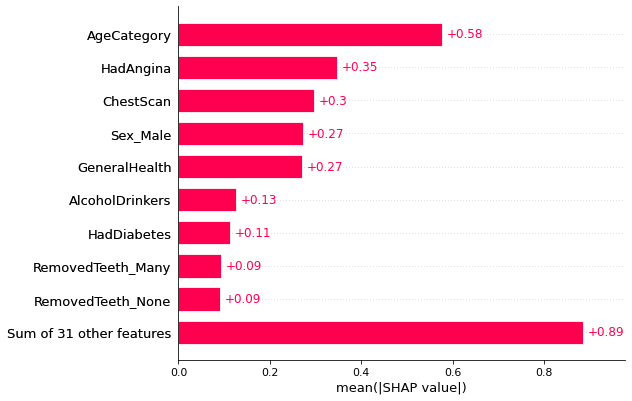

In [28]:
shap.plots.bar(shap_values)

The features that appear to be most important in explaining the variation in the probability of a heart attack are:
- demographics: age group and being male
- habits: alcohol consumption
- comorbidities: diabetes, multiple tooth extractions (or no tooth extraction), general health
- heart problems: suffering from angina or having a chest CT scan

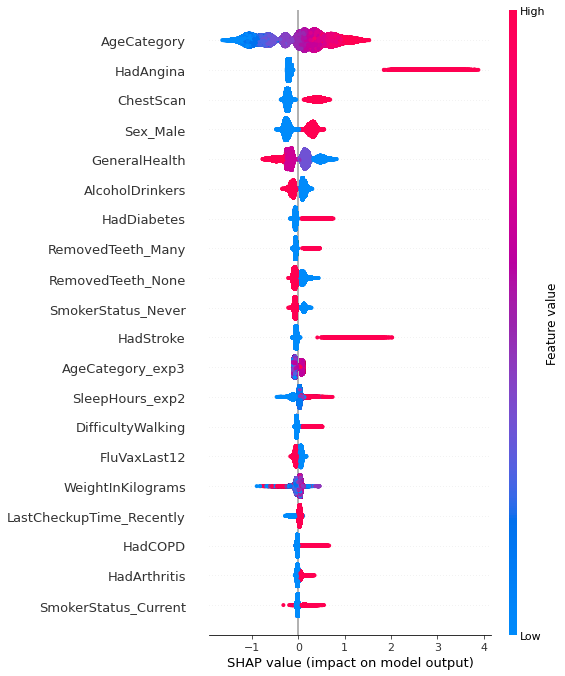

In [29]:
shap.summary_plot(shap_values, X_train)

The figure above illustrates the relationship between the values ​​of several features and the probability of developing heart disease predicted by the model. Most of the features listed in this figure have a monotonic effect, and most of the Shapley values ​​are consistent with effects already observed in the medical literature:
- The risk of heart attack increases with age and is higher in people with age-related diseases (e.g., diabetes, arthritis) or cardiovascular diseases (e.g., angina, stroke, or a recent chest CT scan).
- Never having smoked tobacco has a protective effect, while tobacco-related COPD increases the risk.
- The risk of heart attack is primarily associated with general health variables: it decreases in people with a high general health score and who have never had a tooth extracted, while it increases in those who have had multiple tooth extractions and have difficulty walking.
- Surprisingly, Shapley values ​​are negative for alcohol drinkers, suggesting that alcohol consumption would be associated with a lower risk of heart attack (which is in complete contradiction with the scientific and medical consensus). Moreover, the effect of body weight is not monotonic and appears difficult to interpret globally. These results suggests some caution in interpreting our model, especially since it still has relatively high false positive and false negative rates on the test dataset.

We can also try to focus on a few individual cases to see how the features impact the overall prediction of the model.

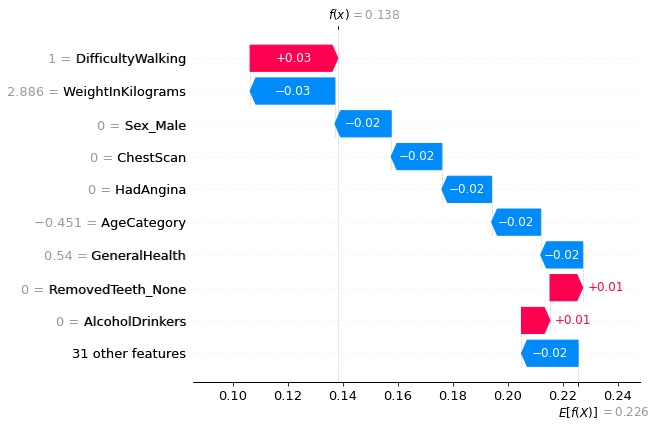

In [33]:
shap.plots.waterfall(uu.convert_shap_logit(shap_values[0]))

In this person's case, the model estimates a relatively moderate risk of heart attack (logit = 0.138, corresponding to a probability of 0.534). Starting with a baseline logit risk of 0.226 (corresponding to a probability of 0.556), the patient benefits from the protective effects of good general health, young age, the absence of angina or chest scans, being female, and relatively high body mass. However, her risk of heart attack increases due to her difficulty walking, history of tooth extraction, and non-alcohol consumption.

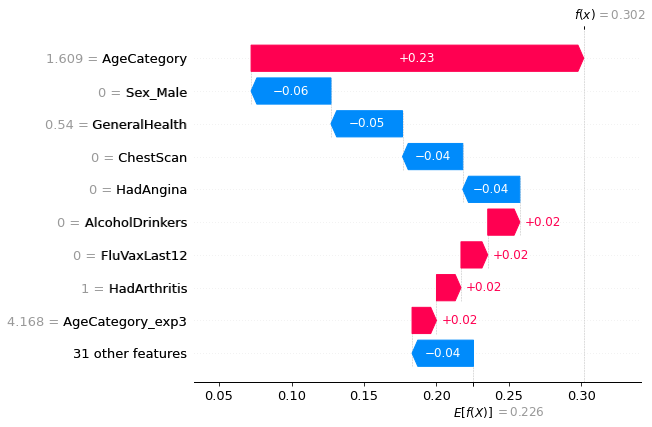

In [34]:
shap.plots.waterfall(uu.convert_shap_logit(shap_values[100]))

In this person's case, the model estimates a relatively higher risk of heart attack (logit = 0.302, corresponding to a probability of 0.575). From the same starting point, the patient benefits from the protective effects of good general health, the absence of angina or chest CT scans, and being a woman. However, her risk of heart attack increases slightly because she does not drink alcohol, has arthritis, and has not recently received a flu shot, but it increases mainly because of her relatively old age.